In [570]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [571]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = _children
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data = {self.data})'
    
    def __neg__(self):
        return self * -1
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int/float for now'
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward

        return out

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        self.grad = 1.0

        topo = []
        visited = set()
        def build_topo(v):
            if not v in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        for node in reversed(topo):
            node._backward()

In [572]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data = -2.0)

In [573]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = '{ %s | data %.4f | grad %.4f }' % (n.label, n.data, n.grad), shape='record')

        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

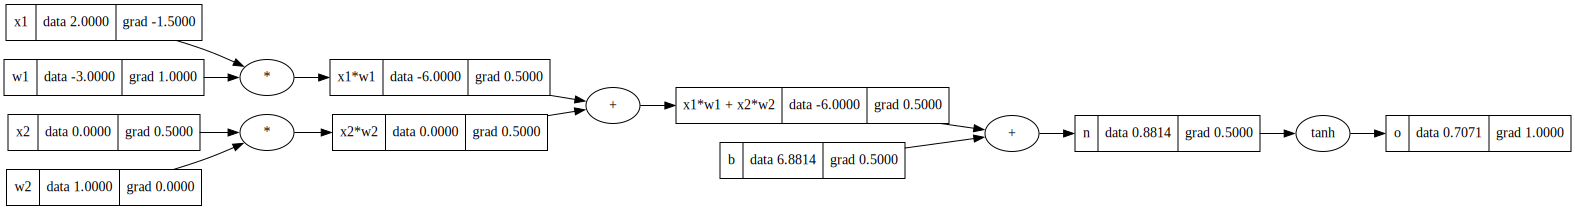

In [574]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# output
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

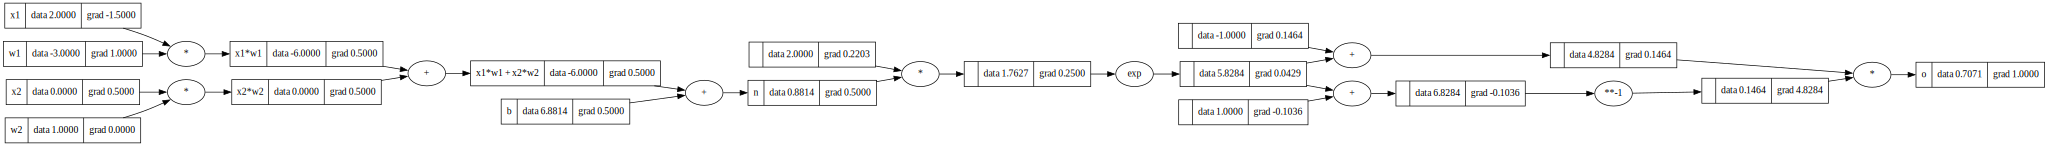

In [575]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# output
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)

# Pytorch Implementation

In [576]:
import torch

x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b

o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# Neural Networks

In [577]:
import random

In [578]:
class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x: Value) -> Value:
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [579]:
class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [580]:
class MLP:
    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [581]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = 0.5080216030836472)

In [582]:
# set of inputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

# desired outputs
ys = [1.0, -1.0, -1.0, 1.0]

In [583]:
for k in range(500):
    # Forward Pass
    ypred = [n(x) for x in xs]
    loss = sum([((yout - ygt)**2) for ygt, yout in zip(ys, ypred)])

    # Backward Pass 
    for p in n.parameters():
        p.grad = 0.0

    loss.backward()

    # Update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 5.0128200505671305
1 2.748195048474159
2 4.461883193857193
3 0.09377798031505793
4 0.06855743413377147
5 0.05439798161758778
6 0.045075325843947245
7 0.03842495313335465
8 0.0334331950047217
9 0.029548391650011947
10 0.026440966334541644
11 0.023900800879475048
12 0.021787261487326876
13 0.020002559306648814
14 0.018476558825365082
15 0.017157645402684413
16 0.016006995931781808
17 0.014994854886094106
18 0.014098040122393057
19 0.013298228674592554
20 0.012580751831355015
21 0.011933731257225593
22 0.011347448637066201
23 0.010813878417246866
24 0.010326336493487858
25 0.009879212653887573
26 0.009467764406598807
27 0.009087956395030985
28 0.008736334080937559
29 0.008409923474702395
30 0.008106150868626351
31 0.007822778078370354
32 0.0075578498144536176
33 0.007309650619976906
34 0.007076669410869738
35 0.006857570101714096
36 0.006651167135898373
37 0.006456404993331472
38 0.006272340943445312
39 0.006098130461027194
40 0.005933014838664627
41 0.0057763106204008225
42 0.005627400

In [584]:
ypred

[Value(data = 0.9931889997027966),
 Value(data = -0.9900227892005893),
 Value(data = -0.9880005228401797),
 Value(data = 0.9894148119564675)]